In [1]:
from svsuperestimator.reader import *
from svsuperestimator.tasks import taskutils, plotutils
import numpy as np
from rich import print
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import json
from matplotlib import style, rcParams
import os

import pandas as pd

try:
    this_file_dir = os.path.abspath(os.path.dirname(__file__))
except NameError:
    this_file_dir = "/Users/jakobrichter/code/paper-tools"

style.use(os.path.join(this_file_dir, "matplotlibrc"))

width = rcParams["figure.figsize"][0]

zerod_path = lambda x: f"/Volumes/richter/final_data/grid_sampling/sample_configs/sample_{x}.json"

result_path = lambda x: f"/Volumes/richter/final_data/grid_sampling/results/grid_sampling_3d_february2024_{x}/adaptive_three_d_simulation/result_cycle_2.vtp"

centerline = CenterlineHandler.from_file("/Volumes/richter/final_data/centerlines/0104_0001.vtp")

project = SimVascularProject("/Volumes/richter/final_data/projects/0104_0001")
handler3d = project["3d_simulation_input"]

noise_factor = 0.3
y_obs = np.array([9.32312464e+04, 1.77669235e+05, 7.44259475e+00, 3.38493067e+01, 6.52259072e+00, 2.25376025e+00, 6.43813231e+00])
likelihood = stats.multivariate_normal(mean=np.zeros(len(y_obs)))
likelihood_std_vector = noise_factor * y_obs

def get_targets(i):

    threed_result_handler = CenterlineHandler.from_file(result_path(i), padding=True)

    zerod_handler = SvZeroDSolverInputHandler.from_file(zerod_path(i))

    bc_map = zerod_handler.vessel_to_bc_map

    branch_data_3d, times = taskutils.map_centerline_result_to_0d_3(
        zerod_handler,
        centerline,
        handler3d,
        threed_result_handler,
    )

    p_inlet = np.array(branch_data_3d[0][0]["pressure_in"])

    q_outlet_mean = []

    # print(branch_data_3d)

    for key, value in bc_map.items():
        if key.startswith("RCR"):
            branch_id = value["name"].split("_")
            seg_id = int(branch_id[1].removeprefix("seg"))
            branch_id = int(branch_id[0].removeprefix("branch"))

            q_outlet_mean.append(np.mean(branch_data_3d[branch_id][seg_id]["flow_out"]))

    return np.array([p_inlet.min(), p_inlet.max(), *q_outlet_mean])

def get_likelihood(i):

    results = get_targets(i)

    return likelihood.pdf(
        (np.array(results) - y_obs) / likelihood_std_vector
    )

def joint_plot(
    x: np.ndarray,
    y: np.ndarray,
    weights: np.ndarray,
    lims: list,
    output_path: str,
    color_map: str = "BuGn",
):
    plot = sns.JointGrid()

    # Create kernel density plot for joint plot
    sns.kdeplot(
        x=x,
        y=y,
        weights=weights,
        color="r",
        fill=True,
        cmap="BuGn",
        ax=plot.ax_joint,
        thresh=0.01,
    )

    # Get color for marginal plots
    cmap = plt.get_cmap(color_map)
    color = np.array(cmap(1000))[:-1]

    # Create marginal plots
    plot.ax_marg_x.hist(x=x, weights=weights, color=color, alpha=0.5)
    plot.ax_marg_y.hist(
        x=y, weights=weights, orientation="horizontal", color=color, alpha=0.5
    )

    # Set limits
    plot.ax_joint.set_xlim(lims[0])
    plot.ax_joint.set_ylim(lims[1])

    plt.savefig(output_path)
    plt.close()


prior_bounds = [[2.0, 8.0], [3.0, 6.0]]

ranges = [
    np.linspace(
        prior_bounds[i][0],
        prior_bounds[i][1],
        10,
    )
    for i in range(2)
]

all_particles = np.array(np.meshgrid(*ranges)).T.reshape(
    -1, 2
)
x = all_particles[:, 0]
y = all_particles[:, 1]

calibrated_data = "/Volumes/richter/final_data/projects/0104_0001/ParameterEstimation/grid_sampling_february2024_calibrated/taskdata.json"
geometric_data = "/Volumes/richter/final_data/projects/0104_0001/ParameterEstimation/grid_sampling_february2024_geometric/taskdata.json"

with open(calibrated_data) as ff:
    calibrated_data = json.load(ff)

with open(geometric_data) as ff:
    geometric_data = json.load(ff)

weights_cali = calibrated_data["weights"][-1]
weights_geo = geometric_data["weights"][-1]
weights_3d = np.array([get_likelihood(i) for i in range(100)])
weights_3d /= np.sum(weights_3d)

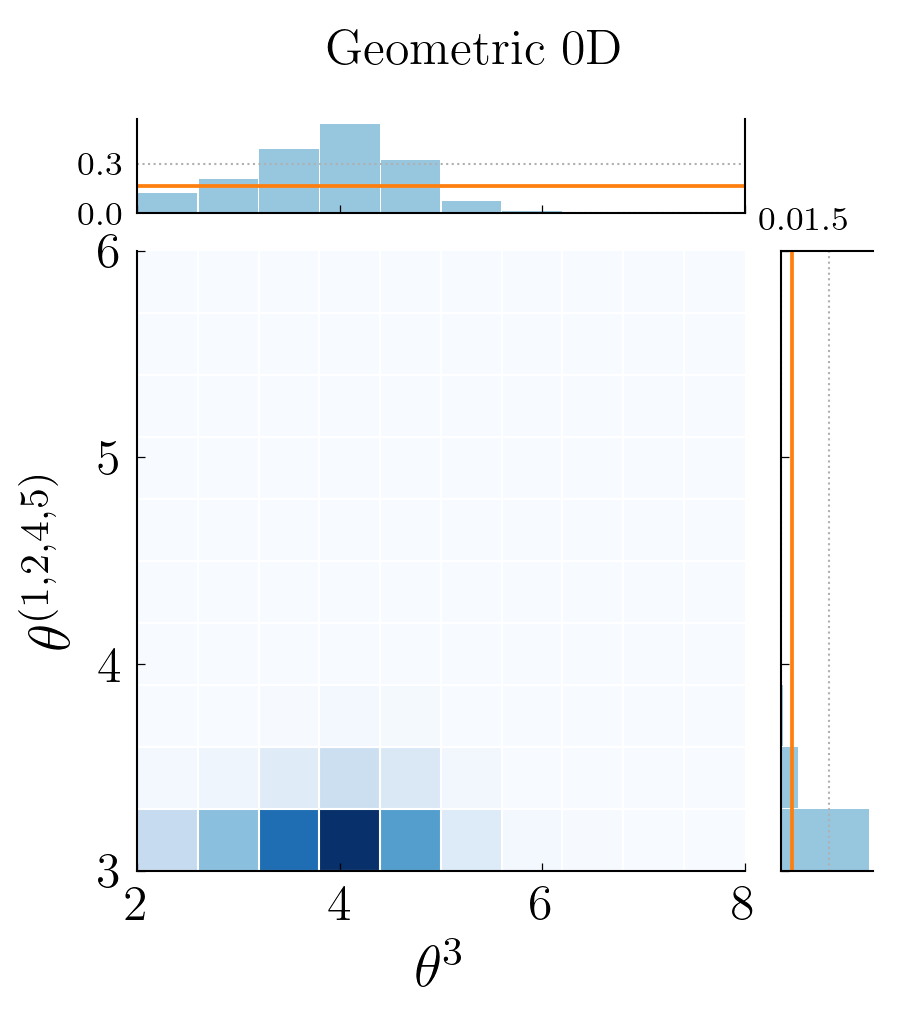

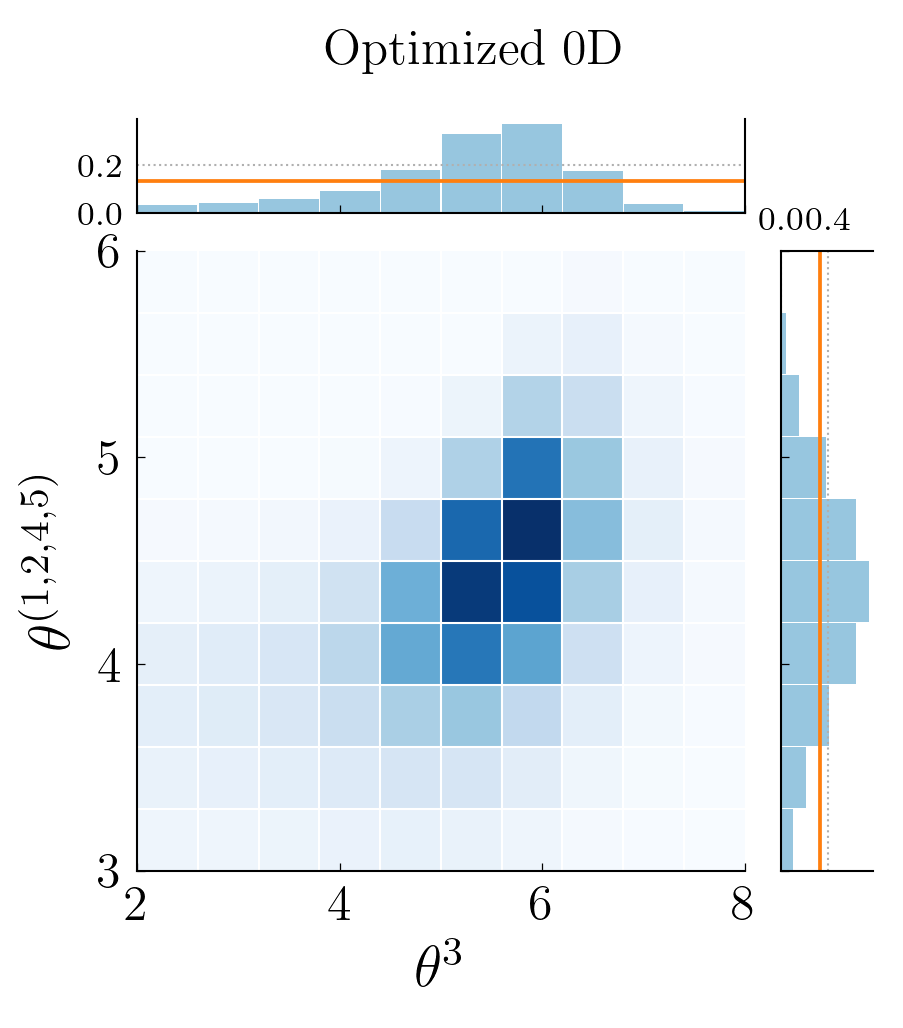

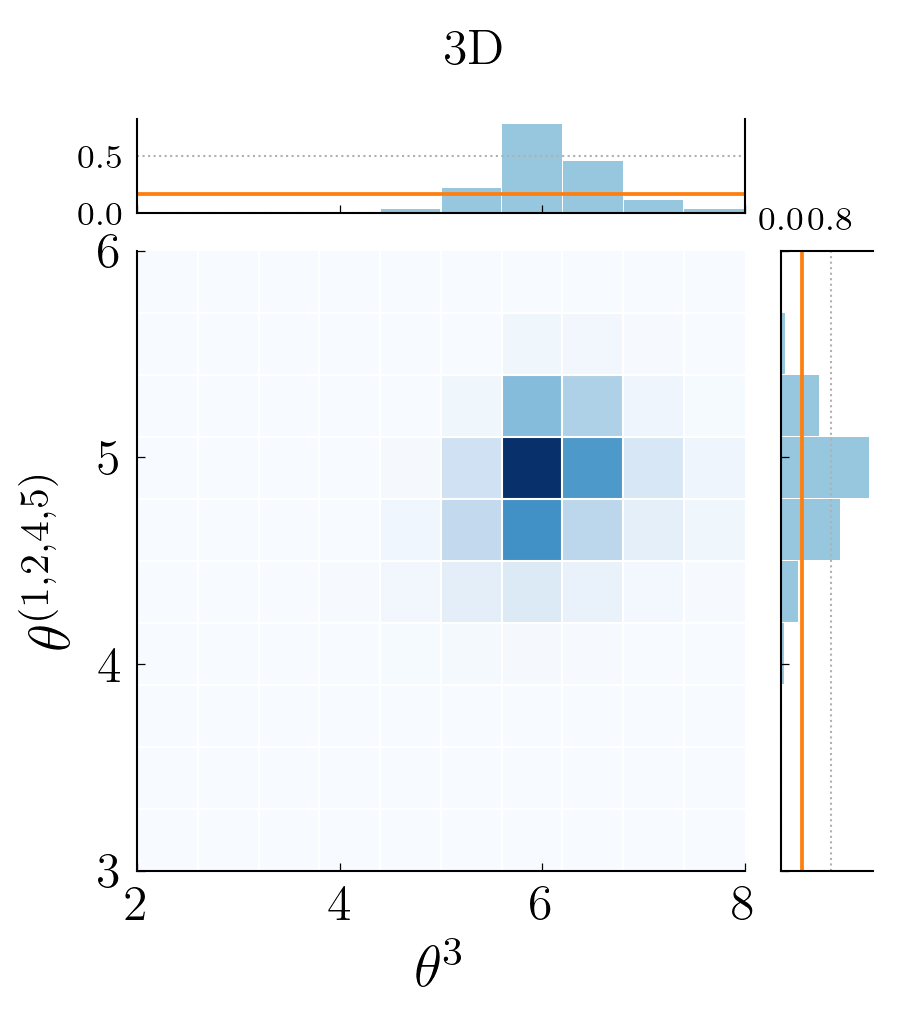

In [9]:
from matplotlib.ticker import MaxNLocator

def joint_plot(
    x: np.ndarray,
    y: np.ndarray,
    weights: np.ndarray,
    lims: list,
    output_path: str,
    title
):
    plot = sns.JointGrid(height=width*1.5/3, space=0.4)

    color_map="Blues"

    sns.histplot(
        x=x,
        y=y,
        weights=weights,
        color="r",
        # fill=False,
        cmap=color_map,
        ax=plot.ax_joint,
        thresh=0.000,
        bins=10,
        linewidth=0.75,
        shrink=0.9
        # hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0}
    )

    for xi in np.linspace(lims[0][0], lims[0][1], 10, endpoint=False):
        plot.ax_joint.axvline(xi, color="white", linewidth=0.5)
    for yi in np.linspace(lims[1][0], lims[1][1], 10, endpoint=False):
        plot.ax_joint.axhline(yi, color="white", linewidth=0.5)

    # Create kernel density plot for joint plot
    # sns.kdeplot(
    #     x=x,
    #     y=y,
    #     weights=weights,
    #     color="r",
    #     # fill=True,
    #     cmap=color_map,
    #     ax=plot.ax_joint,
    #     thresh=0.00,
    #     levels=4
    # )

    plot.ax_joint.set_xlabel(r"$\theta^{3}$")
    plot.ax_joint.set_ylabel(r"$\theta^{(1,2,4,5)}$")

    # Get color for marginal plots
    cmap = plt.get_cmap(color_map)
    color = np.array(cmap(100))[:-1]

    # Create marginal plots
    plot.ax_marg_x.hist(x=x, weights=weights, color=color, alpha=1.0, bins=10, density=True, label="Posterior", rwidth=0.98)
    plot.ax_marg_x.plot([min(x), max(x)], [1/6, 1/6], color="tab:orange")
    plot.ax_marg_y.hist(
        x=y, weights=weights, orientation="horizontal", color=color, alpha=1.0, bins=10, density=True, rwidth=0.98
    )
    plot.ax_marg_y.plot([1/3, 1/3], [min(y), max(y)], color="tab:orange")
    # sns.kdeplot(x=x, weights=weights, linewidth=1, ax=plot.ax_marg_x)
    # sns.kdeplot(y=y, weights=weights, linewidth=1, ax=plot.ax_marg_y)

    plot.ax_joint.set_xticks([2, 4, 6, 8], [2, 4, 6, 8])
    plot.ax_joint.set_yticks([3, 4, 5, 6], [3, 4, 5, 6])
    plot.ax_joint.tick_params(axis='both', which='major', labelsize=12)
    plot.ax_joint.yaxis.get_label().set_fontsize(14)
    plot.ax_joint.xaxis.get_label().set_fontsize(14)
    
    # [[2.0, 8.0], [3.0, 6.0]]

    # Set limits
    plot.ax_joint.set_xlim(lims[0])
    plot.ax_joint.set_ylim(lims[1])
    # plt.legend()

    # sns.despine(ax=plot.ax_marg_x)
    # sns.despine(ax=plot.ax_marg_y)
    plot.ax_marg_y.tick_params(labeltop=True)
    plot.ax_marg_y.grid(True, axis='x', ls=':')
    plot.ax_marg_y.xaxis.set_major_locator(MaxNLocator(2))
    plot.ax_marg_y.xaxis.set_major_formatter('{x:.1f}')
    plot.ax_marg_y.spines[["top", "bottom"]].set_visible(True)

    plot.ax_marg_x.tick_params(labelleft=True)
    plot.ax_marg_x.grid(True, axis='y', ls=':')
    plot.ax_marg_x.yaxis.set_major_locator(MaxNLocator(2))
    plot.ax_marg_x.yaxis.set_major_formatter('{x:.1f}')
    plot.ax_marg_x.spines[["left", "right"]].set_visible(True)

    # plt.tig
    plt.suptitle(title, y=1.05)
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()

joint_plot(x, y, weights_geo, prior_bounds, output_path="/Volumes/richter/final_data/grid_sampling/plots/grid_geo.svg", title="Geometric 0D")
joint_plot(x, y, weights_cali, prior_bounds, output_path="/Volumes/richter/final_data/grid_sampling/plots/grid_cali.svg", title="Optimized 0D")
joint_plot(x, y, weights_3d, prior_bounds, output_path="/Volumes/richter/final_data/grid_sampling/plots/grid_3d.svg", title="3D")